**Environment Setup & Hugging Face Login**

In [1]:
!pip install --upgrade transformers huggingface_hub

In [2]:
# --- INSTALLING LIBRARIES ---
!pip install transformers[torch] datasets scikit-learn sentencepiece sacremoses accelerate -q

# --- IMPORTING LIBRARIES ---
import pandas as pd
import numpy as np
import torch
from google.colab import drive
from huggingface_hub import notebook_login
from transformers import AutoTokenizer, TrainingArguments, Trainer, pipeline, DistilBertModel
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

# --- MOUNTING GOOGLE DRIVE ---
drive.mount('/content/drive')

# --- LOGGING INTO HUGGING FACE ---
notebook_login()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Mount Google Drive & set all paths**

In [3]:
# --- LOADING THE DATASET ---
FILE_PATH = '/content/drive/MyDrive/THESIS 47/Saved Datasets/[Non English reviews deleted] All_Language_Data.csv'
df = pd.read_csv(FILE_PATH)

# --- DATA CLEANING AND LABEL CREATION ---
df.dropna(subset=['reviewText', 'originalScore'], inplace=True)
bins = [0, 2, 4, 6, 8, 10]
labels = [0, 1, 2, 3, 4]
class_names = ['Very Negative', 'Negative', 'Average', 'Positive', 'Very Positive']
df['label'] = pd.cut(df['originalScore'], bins=bins, labels=labels, right=True, include_lowest=True)

# --- DISPLAYING INITIAL CLASS DISTRIBUTION ---
print("--- Class Distribution Before Resampling ---")
print(df['label'].value_counts().sort_index())

--- Class Distribution Before Resampling ---
label
0    11436
1    40617
2    57315
3    64737
4    20696
Name: count, dtype: int64


**Data Resampling (Upsampling & Downsampling)**

In [4]:
# --- INITIALIZING BACK-TRANSLATION PIPELINE ---
print("Initializing back-translation models...")
device = "cuda" if torch.cuda.is_available() else "cpu"
en_to_de_translator = pipeline("translation_en_to_de", model="Helsinki-NLP/opus-mt-en-de", device=device)
de_to_en_translator = pipeline("translation_de_to_en", model="Helsinki-NLP/opus-mt-de-en", device=device)

# --- SEPARATING DATAFRAMES BY CLASS ---
df_class_0 = df[df['label'] == 0]
df_class_1 = df[df['label'] == 1]
df_class_2 = df[df['label'] == 2]
df_class_3 = df[df['label'] == 3]
df_class_4 = df[df['label'] == 4]

# --- BATCHED UPSAMPLING ---
num_to_generate = 15000 - len(df_class_0)
samples_to_augment = df_class_0.sample(n=num_to_generate, replace=True, random_state=42)
texts_to_translate = samples_to_augment['reviewText'].tolist()
print(f"\nAugmenting {num_to_generate} samples using batching...")
de_translations = en_to_de_translator(texts_to_translate, batch_size=32, truncation=True)
de_texts = [item['translation_text'] for item in de_translations]
en_translations = de_to_en_translator(de_texts, batch_size=32, truncation=True)
augmented_texts = [item['translation_text'] for item in en_translations]
df_augmented = pd.DataFrame({'reviewText': augmented_texts, 'label': 0})
df_class_0_upsampled = pd.concat([df_class_0, df_augmented])

# --- DOWNSAMPLING ---
df_class_2_downsampled = df_class_2.sample(n=40000, random_state=42)
df_class_3_downsampled = df_class_3.sample(n=45000, random_state=42)

# --- COMBINING RESAMPLED DATA ---
df_resampled = pd.concat([
    df_class_0_upsampled,
    df_class_1,
    df_class_2_downsampled,
    df_class_3_downsampled,
    df_class_4
])
print("\n--- Class Distribution After Resampling ---")
print(df_resampled['label'].value_counts().sort_index())


Initializing back-translation models...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cuda
Device set to use cuda



Augmenting 3564 samples using batching...

--- Class Distribution After Resampling ---
label
0    15000
1    40617
2    40000
3    45000
4    20696
Name: count, dtype: int64


***Multimodal Feature Preprocessing***

In [5]:
# --- PREPARING MULTIMODAL FEATURES ---
df_full = pd.read_csv(FILE_PATH)
df_full['label'] = pd.cut(df_full['originalScore'], bins=bins, labels=labels, right=True, include_lowest=True)
df_multimodal = df_full.loc[df_resampled.index].copy()

# --- HANDLING MISSING VALUES AND PREPROCESSING ---
df_multimodal['tomatoMeter'].fillna(df_multimodal['tomatoMeter'].median(), inplace=True)
df_multimodal['genre'].fillna("Unknown", inplace=True)
df_multimodal['title'].fillna("", inplace=True)
scaler = StandardScaler()
df_multimodal['tomatometer_scaled'] = scaler.fit_transform(df_multimodal[['tomatoMeter']])
df_multimodal['genre_list'] = df_multimodal['genre'].str.split(', ')
mlb = MultiLabelBinarizer()
genre_binarized = mlb.fit_transform(df_multimodal['genre_list'])
df_multimodal['combined_text'] = df_multimodal['title'] + " [SEP] " + df_multimodal['reviewText']

# --- CREATING THE FINAL DATAFRAME ---
final_df = df_multimodal[['combined_text', 'label']].copy()
final_df['numerical_features'] = list(df_multimodal['tomatometer_scaled'].values)
final_df['categorical_features'] = list(genre_binarized)

/tmp/ipython-input-1382390985.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_multimodal['tomatoMeter'].fillna(df_multimodal['tomatoMeter'].median(), inplace=True)
/tmp/ipython-input-1382390985.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[c

**Dataset Preparation and Tokenization**

In [6]:
# --- SPLITTING AND CONVERTING TO HUGGING FACE DATASET ---
train_df, test_df = train_test_split(final_df, test_size=0.2, random_state=42, stratify=final_df['label'])
raw_multimodal_datasets = DatasetDict({
    'train': Dataset.from_pandas(train_df),
    'test': Dataset.from_pandas(test_df)
})

# --- TOKENIZATION ---
MODEL_CHECKPOINT = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)
def tokenize_multimodal_function(examples):
    return tokenizer(examples["combined_text"], padding="max_length", truncation=True, max_length=256)
tokenized_multimodal_datasets = raw_multimodal_datasets.map(tokenize_multimodal_function, batched=True)
tokenized_multimodal_datasets = tokenized_multimodal_datasets.remove_columns(["combined_text", "__index_level_0__"])
tokenized_multimodal_datasets.set_format("torch")

Map:   0%|          | 0/129050 [00:00<?, ? examples/s]

Map:   0%|          | 0/32263 [00:00<?, ? examples/s]

**Custom Model and Data Collator**

In [11]:
# --- DEFINING THE CUSTOM MULTIMODAL MODEL ---
class MultimodalClassifier(nn.Module):
    def __init__(self, num_labels, num_numerical_features, num_categorical_features):
        super(MultimodalClassifier, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained(MODEL_CHECKPOINT)
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(
            self.distilbert.config.hidden_size + num_numerical_features + num_categorical_features,
            num_labels
        )
        self.num_labels = num_labels

    def forward(self, input_ids, attention_mask, numerical_features, categorical_features, labels=None):
        distilbert_output = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        cls_token_output = distilbert_output.last_hidden_state[:, 0]
        pooled_output = self.dropout(cls_token_output)
        combined_features = torch.cat([pooled_output, numerical_features, categorical_features], dim=1)
        logits = self.classifier(combined_features)
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        return (loss, logits) if loss is not None else (None, logits)

# ---  CUSTOM MULTIMODAL MODEL ---
class MultimodalClassifier(nn.Module):
    def __init__(self, num_labels, num_numerical_features, num_categorical_features):
        super(MultimodalClassifier, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained(MODEL_CHECKPOINT)
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(
            self.distilbert.config.hidden_size + num_numerical_features + num_categorical_features,
            num_labels
        )
        self.num_labels = num_labels

    def forward(self, input_ids, attention_mask, numerical_features, categorical_features, labels=None):
        distilbert_output = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        cls_token_output = distilbert_output.last_hidden_state[:, 0]
        pooled_output = self.dropout(cls_token_output)

        # --- THIS IS THE FIX ---
        # Reshape the 1D numerical_features tensor to be 2D before concatenating
        numerical_features = numerical_features.unsqueeze(1)

        combined_features = torch.cat([pooled_output, numerical_features, categorical_features], dim=1)
        logits = self.classifier(combined_features)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return (loss, logits) if loss is not None else (None, logits)

**Training the Multimodal Model**

In [16]:
# --- INITIALIZING THE CUSTOM MODEL AND COLLATOR ---
num_numerical_features = 1
num_categorical_features = len(mlb.classes_)
multimodal_model = MultimodalClassifier(
    num_labels=len(class_names),
    num_numerical_features=num_numerical_features,
    num_categorical_features=num_categorical_features
)
data_collator = MultimodalDataCollator(tokenizer)


# --- CORRECTED EVALUATION METRICS FUNCTION ---
def compute_metrics(pred):
    labels = pred.label_ids
    # The '.predictions' attribute can be a tuple, so we access the first element.
    # The fix is to remove the extra [0] index that was slicing the array.
    preds = pred.predictions[0].argmax(-1) if isinstance(pred.predictions, tuple) else pred.predictions.argmax(-1)

    # For binary classification, use average='binary'
    average_metric = 'binary' if len(class_names) == 2 else 'weighted'

    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average=average_metric)
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

# --- DEFINING TRAINING ARGUMENTS ---
multimodal_training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/THESIS 47/Saved Datasets/results_multimodal",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
)

# --- INITIALIZING THE TRAINER ---
multimodal_trainer = Trainer(
    model=multimodal_model,
    args=multimodal_training_args,
    train_dataset=tokenized_multimodal_datasets["train"],
    eval_dataset=tokenized_multimodal_datasets["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# --- STARTING THE TRAINING ---
print("\n--- Starting Training for Multimodal Model ---")
multimodal_trainer.train()


--- Starting Training for Multimodal Model ---


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.114300,1.089942,0.508942,0.476509,0.516884,0.508942
2,0.977300,1.086927,0.522797,0.513390,0.526793,0.522797
3,0.855900,1.143437,0.524316,0.519651,0.523025,0.524316


TrainOutput(global_step=24198, training_loss=0.9984980629775059, metrics={'train_runtime': 8316.075, 'train_samples_per_second': 46.554, 'train_steps_per_second': 2.91, 'total_flos': 0.0, 'train_loss': 0.9984980629775059, 'epoch': 3.0})

**Final Evaluation and Saving**

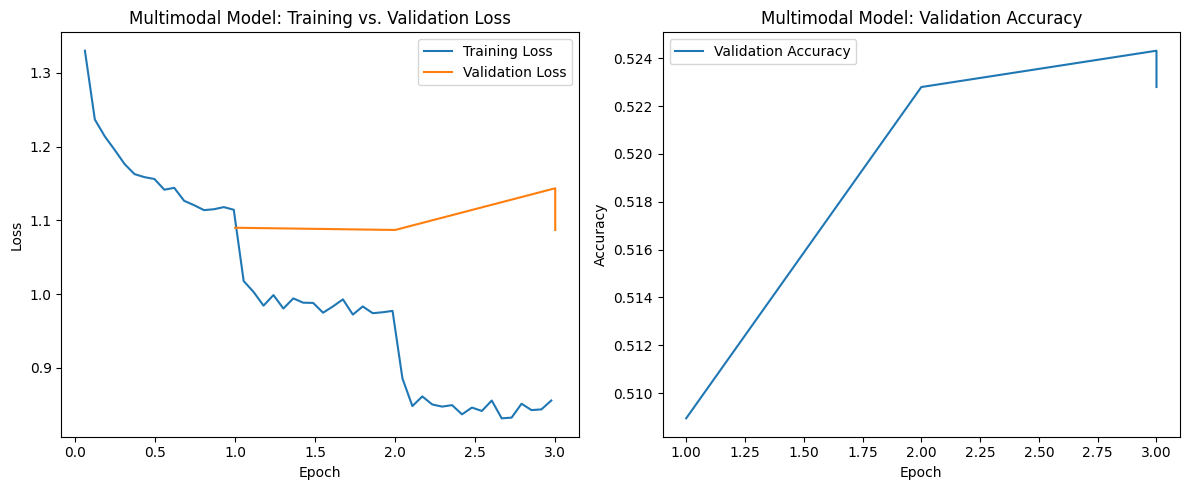


--- Final Evaluation on Test Set (Multimodal) ---


{'eval_loss': 1.0869271755218506, 'eval_accuracy': 0.5227970120571552, 'eval_f1': 0.5133897718205604, 'eval_precision': 0.5267927040488372, 'eval_recall': 0.5227970120571552, 'eval_runtime': 206.0131, 'eval_samples_per_second': 156.607, 'eval_steps_per_second': 9.791, 'epoch': 3.0}

--- Classification Report (Multimodal) ---
               precision    recall  f1-score   support

Very Negative       0.60      0.17      0.27      2326
     Negative       0.53      0.61      0.57      8275
      Average       0.44      0.44      0.44      8210
     Positive       0.55      0.64      0.59      9244
Very Positive       0.59      0.45      0.51      4208

     accuracy                           0.52     32263
    macro avg       0.54      0.46      0.48     32263
 weighted avg       0.53      0.52      0.51     32263



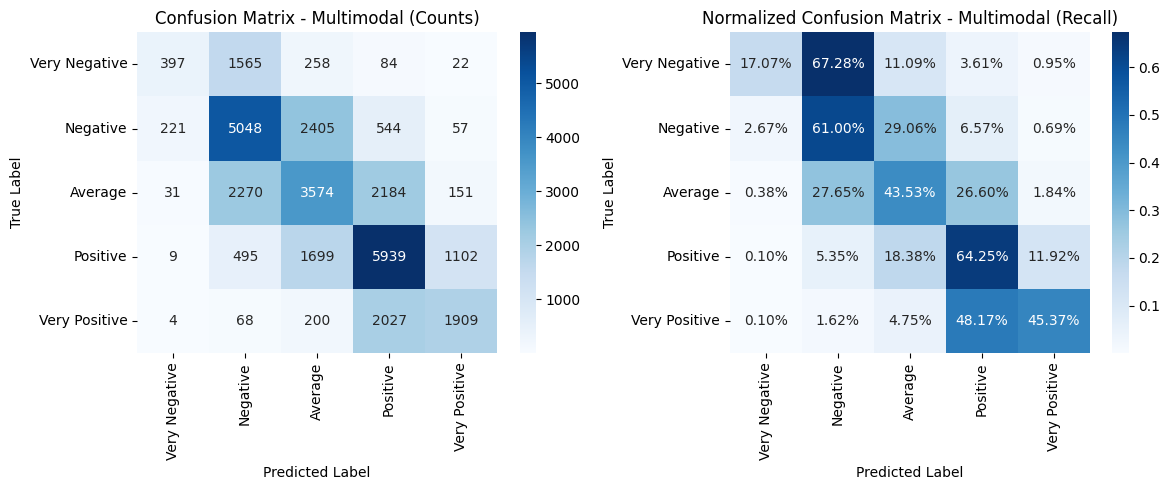

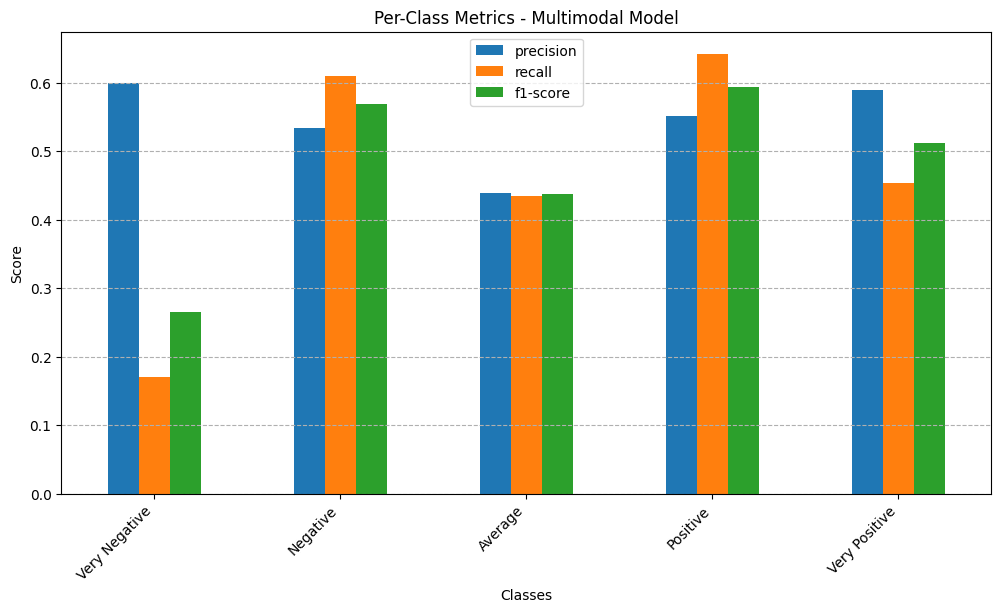


Multimodal model saved to /content/drive/MyDrive/THESIS 47/Saved Datasets/fine-tuned-multimodal-model


In [19]:
# --- EXTRACTING TRAINING HISTORY ---
# The trainer's log history contains the loss and metrics from training and validation.
log_history = multimodal_trainer.state.log_history

# Separate training and validation logs
train_logs = [log for log in log_history if ('loss' in log) and ('eval_loss' not in log)]
eval_logs  = [log for log in log_history if ('eval_loss' in log)]

# --- 1. PLOTTING TRAINING VS VALIDATION LOSS ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot([log.get('epoch', i) for i, log in enumerate(train_logs, 1)],
         [log['loss'] for log in train_logs], label='Training Loss')
plt.plot([log.get('epoch', i) for i, log in enumerate(eval_logs, 1)],
         [log['eval_loss'] for log in eval_logs], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Multimodal Model: Training vs. Validation Loss')
plt.legend()

# --- 2. PLOTTING TRAINING VS VALIDATION ACCURACY ---
plt.subplot(1, 2, 2)
if len(eval_logs) > 0 and 'eval_accuracy' in eval_logs[-1]:
    plt.plot([log.get('epoch', i) for i, log in enumerate(eval_logs, 1)],
             [log['eval_accuracy'] for log in eval_logs], label='Validation Accuracy')
else:
    # Avoid breaking if eval_accuracy wasn't logged
    plt.plot([], [], label='Validation Accuracy (not logged)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Multimodal Model: Validation Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# --- FINAL EVALUATION ON TEST SET ---
print("\n--- Final Evaluation on Test Set (Multimodal) ---")
multimodal_eval_results = multimodal_trainer.evaluate()
print(multimodal_eval_results)

# --- GENERATING PREDICTIONS ---
pred_out = multimodal_trainer.predict(tokenized_multimodal_datasets["test"])

logits = pred_out.predictions
if isinstance(logits, (list, tuple)):
    logits = logits[0]

logits = np.asarray(logits)

# Determine number of labels, if available
num_labels = getattr(getattr(multimodal_trainer, "model", None), "config", None)
num_labels = getattr(num_labels, "num_labels", None)

# Turn logits into predicted class indices robustly
if logits.ndim == 2:
    # Standard multi-class: (N, C)
    multimodal_predicted_labels = logits.argmax(axis=-1)
elif logits.ndim == 1:
    # Binary/regression style head
    if num_labels == 1:
        # Regression or single-logit binary; threshold at 0.5 for binary
        # (Change thresholding as appropriate for your setup.)
        multimodal_predicted_labels = (logits > 0.5).astype(int)
    elif num_labels == 2:
        # Single logit binary (sometimes returned as shape (N,))
        multimodal_predicted_labels = (logits > 0).astype(int)
    else:
        # Already class ids (rare but possible)
        multimodal_predicted_labels = logits.astype(int)
else:
    raise ValueError(f"Unexpected logits shape: {logits.shape}")

true_labels = np.array(tokenized_multimodal_datasets["test"]["label"])

# --- 3. CLASSIFICATION REPORT ---
print("\n--- Classification Report (Multimodal) ---")
report_text = classification_report(true_labels, multimodal_predicted_labels, target_names=class_names)
print(report_text)

report = classification_report(true_labels,
                               multimodal_predicted_labels,
                               target_names=class_names,
                               output_dict=True)

# --- 4. CONFUSION MATRIX (RAW COUNTS) ---
cm_multimodal = confusion_matrix(true_labels, multimodal_predicted_labels)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(cm_multimodal, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Multimodal (Counts)')

# --- 5. NORMALIZED CONFUSION MATRIX (RECALL/PERCENTAGES) ---
with np.errstate(invalid='ignore', divide='ignore'):
    row_sums = cm_multimodal.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1  # avoid division by zero
    cm_normalized_multimodal = cm_multimodal.astype(float) / row_sums

plt.subplot(1, 2, 2)
sns.heatmap(cm_normalized_multimodal, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix - Multimodal (Recall)')
plt.tight_layout()
plt.show()

# --- 6. PER-CLASS METRICS BAR CHART ---
report_df_multimodal = pd.DataFrame(report).transpose()
# Keep only your classes (drop accuracy/averages)
metrics_df_multimodal = report_df_multimodal.loc[class_names, ['precision', 'recall', 'f1-score']]
metrics_df_multimodal.plot(kind='bar', figsize=(12, 6))
plt.title('Per-Class Metrics - Multimodal Model')
plt.xlabel('Classes')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--')
plt.show()

# --- SAVING THE MULTIMODAL MODEL ---
output_multimodal_model_path = "/content/drive/MyDrive/THESIS 47/Saved Datasets/fine-tuned-multimodal-model"
multimodal_trainer.save_model(output_multimodal_model_path)
print(f"\nMultimodal model saved to {output_multimodal_model_path}")
